# Benchmark operation on a small rank three tensor.

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def r3py(a):
    """ Take a rank 3 python tensor and set all values to one. """
    I, J, T = len(a[0][0]), len(a[0]), len(a)
    for i in range(I):
        for j in range(J):
            for t in range(T):
                a[t][j][i] = 1

In [3]:
a = [[[0 for _ in range(1024)] for _ in range(1024)] for _ in range(10)]

In [4]:
sys.getsizeof(a[0][0]) * len(a[0]) * len(a)

92405760

Around 8 bytes per entry for a pointer. An integer takes up 28 bytes.

In [5]:
sys.getsizeof(0), sys.getsizeof(1), sys.getsizeof(2**3), sys.getsizeof(2**8), sys.getsizeof(sys.maxsize)

(24, 28, 28, 28, 36)

In [6]:
s = pd.Series([sys.getsizeof(2**i) for i in range(0, 128, 1)])

[]

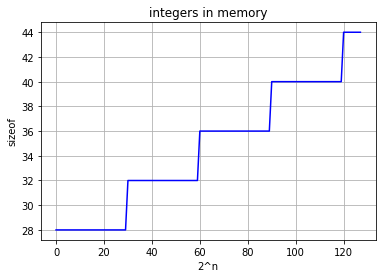

In [7]:
ax = s.plot(kind='line', style='b-', grid=True, title='integers in memory')
ax.set_xlabel('2^n')
ax.set_ylabel('sizeof')
plt.plot()

The 1024x1024x10 pure python array takes up at least 92405760 * 28 bytes (around 2G) in memory.
Let's set the value of each element to some value.

In [8]:
%timeit -r4 r3py(a) # 2.22 s ± 45.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

2.28 s ± 76.5 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


How about floats?

> One of the major challenges in writing (somewhat) large-scale Python programs is to keep memory usage at a minimum.

In [9]:
sys.getsizeof(2.0**1023)

24

In [10]:
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

### Numpy version

In [11]:
import numpy as np

In [12]:
ar = np.zeros((1024, 1024, 10))

In [13]:
ar.nbytes

83886080

In [14]:
ar.dtype

dtype('float64')

The numpy version is much more compact: 83886080 bytes (around 80M). We can set an explicit type.

In [15]:
ar = np.zeros((1024, 1024, 10), dtype='uint8')

In [16]:
ar.nbytes

10485760

Numpy float information.

In [17]:
pd.DataFrame([(np.finfo(f).dtype, np.finfo(f).nexp, np.finfo(f).nmant, np.finfo(f).min, np.finfo(f).max)
              for f in (np.float32, np.float64, np.float128, float)], columns=['name', 'nexp', 'nmant', 'min', 'max'])

,name,nexp,nmant,min,max
0,float32,8,23,-3.402823e+38,3.402823e+38
1,float64,11,52,-1.797693e+308,1.797693e+308
2,float128,15,63,-inf,inf
3,float64,11,52,-1.797693e+308,1.797693e+308


In [18]:
# Let work with ints.

In [19]:
ar = np.zeros((1024, 1024, 10), dtype='uint8')

In [20]:
%timeit ar + 1 # 4.83 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

4.66 ms ± 541 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# PyTorch and GPU

In [21]:
import torch

In [22]:
torch.IntTensor(5, 3).zero_()


 0  0  0
 0  0  0
 0  0  0
 0  0  0
 0  0  0
[torch.IntTensor of size 5x3]

In [23]:
torch.IntTensor(5, 3).zero_() + 1


 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
[torch.IntTensor of size 5x3]

In [24]:
t = torch.IntTensor(1024, 1024, 10).zero_()

In [25]:
%timeit t + 1 # 19.4 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

20.1 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
# t.cuda?

> Returns a copy of this object in CUDA memory.

> If this object is already in CUDA memory and on the correct device, then no copy is performed and the original object is returned.

* OpenCL?

In [27]:
if torch.cuda.device_count():
    gt = t.cuda()
else:
    print("GPU? 乁( ◔ ౪◔)「      ┑(￣Д ￣)┍ ")
    pass # AssertionError: Torch not compiled with CUDA enabled

GPU? 乁( ◔ ౪◔)「      ┑(￣Д ￣)┍ 


Note: Next cells will **only** work on **GPU**.

In [ ]:
gt = t.cuda()

In [ ]:
type(gt)

In [ ]:
gt.size()

In [ ]:
gt.get_device()

In [ ]:
gt.element_size()

In [ ]:
gt.is_cuda

In [ ]:
%timeit gt + 1 # 2.42 ms ± 8.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

In [ ]:
one = torch.IntTensor([1])

In [ ]:
one

In [ ]:
one.is_cuda

In [ ]:
oneg = one.cuda()

In [ ]:
oneg.is_cuda

In [ ]:
%timeit gt + oneg # 2.5 ms ± 7.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)